# Can only use train data to estimate covariance!!! On test sample size is too small...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.data import impute_missing_risk_free, load_data, load_risk_free
from dl_portfolio.backtest import (
    get_target_vol_other_weights, 
    get_factors_rc_and_weights, 
    get_number_of_nmf_bets,
    get_number_of_pc_bets
)
import pickle
import os
import seaborn as sns
import itertools
from dl_portfolio.backtest import get_factors_rc_and_weights, get_number_of_pc_bets, get_number_of_nmf_bets
import time

from dl_portfolio.torsion import get_min_torsion_bets

data1, asset1 = load_data("dataset1")
data2, asset2 = load_data("dataset2")

# Some useful functions

In [2]:
def load_all_backtest_result(nmf_dir, markowitz_dir, dataset):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/dataset1/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
        market_budget.drop("CRIX", inplace=True)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
        
    # Load markowitz and robust M results
    GMV_robust_weights = pd.read_csv(f"{markowitz_dir}/weights_GMV_robust.csv", index_col = 0)
    GMV_robust_weights.index = pd.to_datetime(GMV_robust_weights.index)
    markowitz_weights = pd.read_csv(f"{markowitz_dir}/weights_MeanVar_long.csv", index_col = 0)
    markowitz_weights.index = pd.to_datetime(markowitz_weights.index)
    
    
    port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    aekeys = [c for c in port_weights.keys() if "ae" in c]
    for k in aekeys:
        key = k.replace("ae", "nmf")
        port_weights[key] = port_weights[k]
        port_weights.pop(k)
        
    port_weights["markowitz"] = markowitz_weights.loc[port_weights["rb_factor"].index]
    port_weights["GMV_robust"] = GMV_robust_weights.loc[port_weights["rb_factor"].index]


    cv_results = pd.read_pickle(f"{nmf_dir}/cv_results.p")
    
    return cv_results, port_weights, market_budget


# Save directory

In [6]:
SAVE=True
save=SAVE
savedir = "paper_result_update/nmf"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
perf_nmf_dir_1 = "./performance/test_final_models/nmf/dataset1_20230417_123807"
markowitz_dir1 = "final_models/run_11_dataset1_20230408_145352"
perf_nmf_dir_2 = "./performance/test_final_models/nmf/dataset2_20230417_123835"
markowitz_dir2 = "final_models/run_12_dataset2_20230408_145946"

# Load backtest result

In [15]:
cv_results1, port_weights1, market_budget1 = load_all_backtest_result(perf_nmf_dir_1,
                                                                   markowitz_dir1,
                                                                   "dataset1")
cv_dates1 = [cv_results1[0][cv]["returns"].index[0] for cv in cv_results1[0].keys()]
loading_shape1 = np.array([cv_results1[0][i]["loading"].shape[-1] for i in range(len(cv_dates1))])

cv_results2, port_weights2, market_budget2 = load_all_backtest_result(perf_nmf_dir_2,
                                                                   markowitz_dir2,
                                                                   "dataset2")
cv_dates2 = [cv_results2[0][cv]["returns"].index[0] for cv in cv_results2[0].keys()]
loading_shape2 = np.array([cv_results2[0][i]["loading"].shape[-1] for i in range(len(cv_dates2))])


# Dataset 1

0.006859548886617025
0.00837725003560384


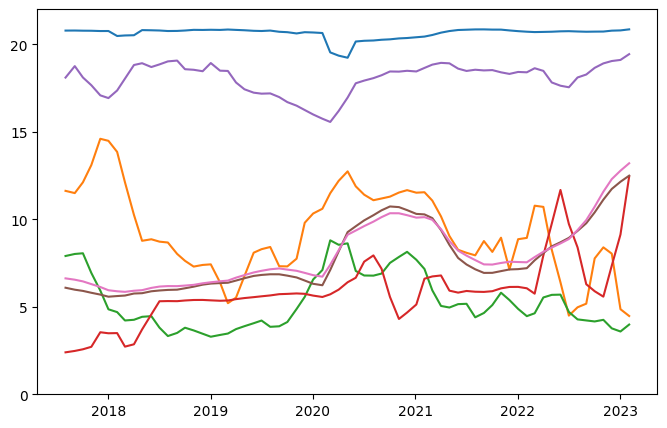

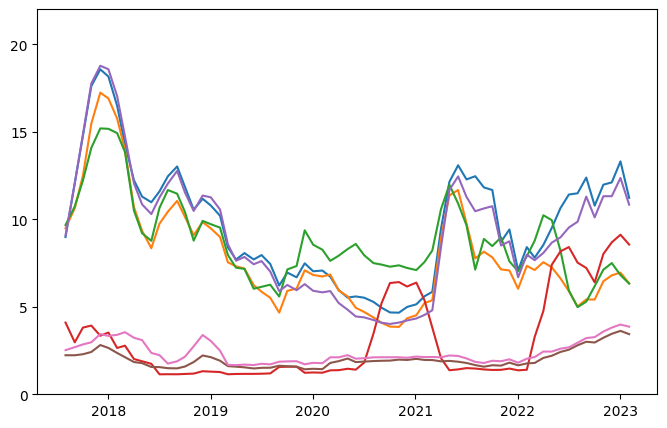

'plt.boxplot(n_bets_a_1.T, showmeans=True)\nplt.xticks(range(1, n_bets_f_1.shape[-1]+1), n_bets_f_1.columns)\nplt.show()\nplt.boxplot(n_bets_f_1.T, showmeans=True)\nplt.xticks(range(1, n_bets_f_1.shape[-1]+1), n_bets_f_1.columns)\nplt.show()'

In [19]:
save = SAVE
t1 = time.time()
rcs_a_1, n_bets_a_1 = get_min_torsion_bets(cv_results1, market_budget1, level="asset")
n_bets_a_1.drop("rb_factor_full_erc", axis=1, inplace=True)
t2 = time.time()
print((t2-t1)/60)

t1 = time.time()
rcs_f_1, n_bets_f_1 = get_min_torsion_bets(cv_results1, market_budget1, level="factor")
n_bets_f_1.drop("rb_factor_full_erc", axis=1, inplace=True)
t2 = time.time()
print((t2-t1)/60)

plt.figure(figsize=(8, 5))
plt.plot(n_bets_a_1.rolling(3).mean())
plt.ylim(0, 22)
plt.yticks(range(0, 22, 5), range(0, 22, 5))
if save:
    plt.savefig(f"{savedir}/min_torsion_a_in_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(n_bets_a_1.columns)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n_bets_f_1.rolling(3).mean()) #  / loading_shape1.reshape(-1,1)
plt.ylim(0, 22)
plt.yticks(range(0, 22, 5), range(0, 22, 5))
if save:
    plt.savefig(f"{savedir}/min_torsion_f_in_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(n_bets_a_1.columns)
plt.show()

"""plt.boxplot(n_bets_a_1.T, showmeans=True)
plt.xticks(range(1, n_bets_f_1.shape[-1]+1), n_bets_f_1.columns)
plt.show()
plt.boxplot(n_bets_f_1.T, showmeans=True)
plt.xticks(range(1, n_bets_f_1.shape[-1]+1), n_bets_f_1.columns)
plt.show()"""

## Dataset 2

In [9]:
t1 = time.time()
rcs_a_2, n_bets_a_2 = get_min_torsion_bets(cv_results2, market_budget2, level="asset")
n_bets_a_2.drop("rb_factor_full_erc", axis=1, inplace=True)
t2 = time.time()
print((t2-t1)/60)

t1 = time.time()
rcs_f_2, n_bets_f_2 = get_min_torsion_bets(cv_results2, market_budget2, level="factor")
n_bets_f_2.drop("rb_factor_full_erc", axis=1, inplace=True)
t2 = time.time()
print((t2-t1)/60)

0.03342478672663371
0.032662983735402426


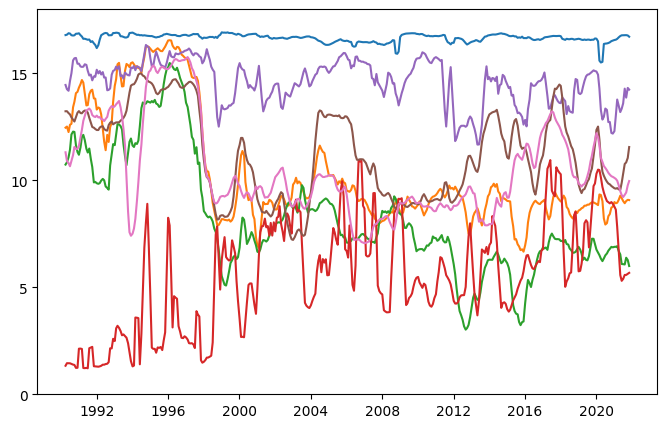

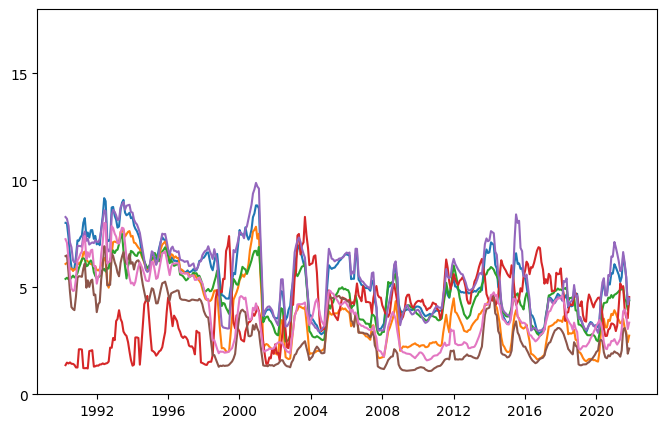

'plt.boxplot(n_bets_a_2.T, showmeans=True)\nplt.xticks(range(1, n_bets_f_2.shape[-1]+1), n_bets_f_2.columns)\nplt.show()\nplt.boxplot(n_bets_f_2.T, showmeans=True)\nplt.xticks(range(1, n_bets_f_2.shape[-1]+1), n_bets_f_2.columns)\nplt.show()'

In [21]:
save = SAVE
plt.figure(figsize=(8, 5))
plt.plot(n_bets_a_2.rolling(3).mean())
plt.ylim(0, 18)
plt.yticks(range(0, 18, 5), range(0, 18, 5))
if save:
    plt.savefig(f"{savedir}/min_torsion_a_in_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(n_bets_a_1.columns)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n_bets_f_2.rolling(3).mean())
plt.ylim(0, 18)
plt.yticks(range(0, 18, 5), range(0, 18, 5))
if save:
    plt.savefig(f"{savedir}/min_torsion_f_in_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(n_bets_a_1.columns)
plt.show()

"""plt.boxplot(n_bets_a_2.T, showmeans=True)
plt.xticks(range(1, n_bets_f_2.shape[-1]+1), n_bets_f_2.columns)
plt.show()
plt.boxplot(n_bets_f_2.T, showmeans=True)
plt.xticks(range(1, n_bets_f_2.shape[-1]+1), n_bets_f_2.columns)
plt.show()"""

## Comments
At both factor and asset level, naive strategies are not diversified with only at around 5 uncorrelated factors contributing to the risk or 8 uncorrelated bets.

HRP and HCAA are not diversified neither at the asset level in particular.


## Comments
At the factor level, all strategies are diversified in a similar way between 5-6 uncorrelated bets.

At the asset level, HCAA and HRP are not diversified.

# Torsion bets is used using the OUTOFSAMPLE COVARIANCE matrix here!
HRP and HCAA do not provide oos diversification

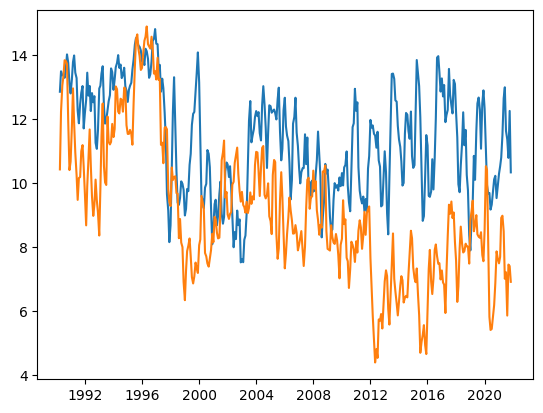

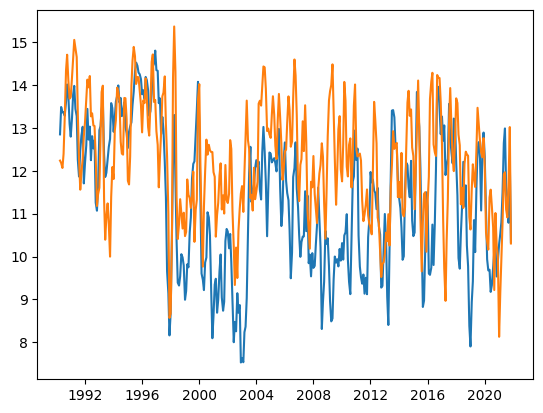

In [26]:
_ = plt.plot(n_bets_a_2.rolling(3).mean()[["equal", "hrp"]])
plt.show()
_ = plt.plot(n_bets_a_2.rolling(3).mean()[["equal", "rb_factor"]])
plt.show()

It seems that rb_factor at the asset level, provides better diversification in particular in periods of crisis.

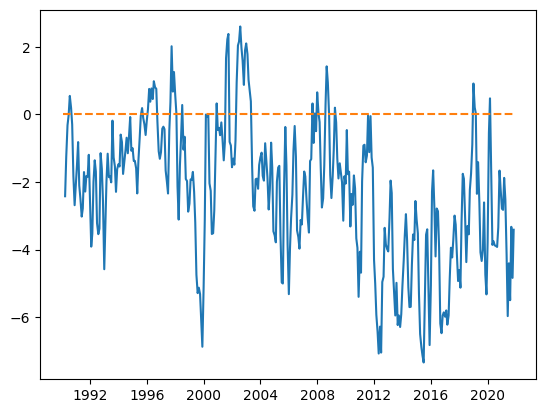

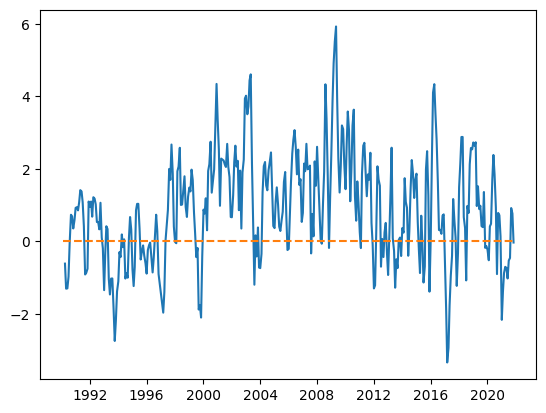

In [35]:
plt.plot((n_bets_a_2["hrp"] - n_bets_a_2["equal"]).rolling(3).mean())
plt.plot(n_bets_a_2["hrp"] * 0., "--")
plt.show()
plt.plot((n_bets_a_2["rb_factor"] - n_bets_a_2["equal"]).rolling(3).mean())
plt.plot(n_bets_a_2["rb_factor"] * 0., "--")
plt.show()

2022-06-02 00:00:00


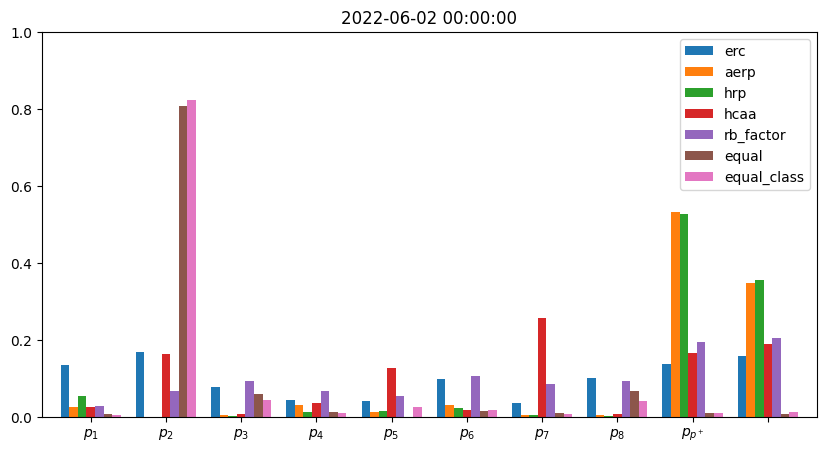

erc
aerp
hrp
hcaa
rb_factor
rb_factor_full_erc
equal
equal_class


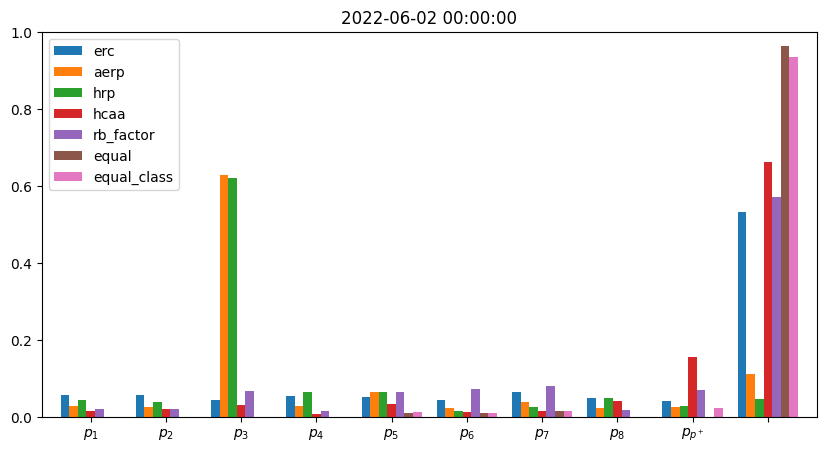

In [11]:
save=False
rc_port1, factor_w_port1 = get_factors_rc_and_weights(cv_results1, market_budget1)

i = 60
date = cv_dates1[i]
print(date)
loading = cv_results1[0][i]["loading"]
p = loading.shape[-1]

rcs = []
for port in rc_port1:
    rc = rc_port1[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rc_port1.keys()).drop("rb_factor_full_erc", axis=1)

rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, p)] + ["$p_{p^+}$"], rotation=0)

plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_covid.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()



rcs = []
for port in rcs_a_1:
    print(port)
    rc = rcs_a_1[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rcs_a_1.keys()).drop("rb_factor_full_erc", axis=1)

rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, p)] + ["$p_{p^+}$"], rotation=0)

plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_mt_covid.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()

erc
aerp
hrp
hcaa
rb_factor
rb_factor_full_erc
equal
equal_class


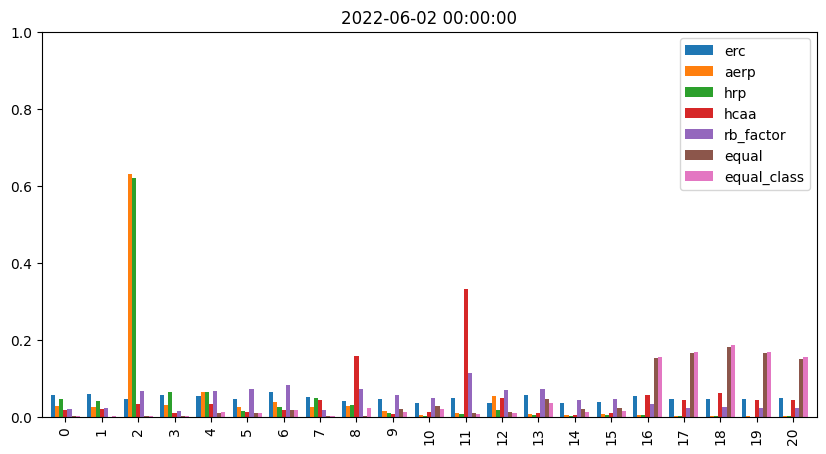

In [9]:
rcs = []
for port in rcs_a_1:
    print(port)
    rc = rcs_a_1[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rcs_a_1.keys()).drop("rb_factor_full_erc", axis=1)

rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
#_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, 4)] + ["$p_{4^+}$"], rotation=0)

plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_mt_covid.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()